# greenwashing_top Project 1

**Project 1:** Private jet pollution attribution

This project aims to increase awareness of the imbalance between individuals relative to pollution to the planet.


>In a world were the future is darker, [_los nadies_](http://rizoma-freireano.org/poema2727/los-nadies-eduardo-galeano) are requested to use less the car, use ventilators instead of ACs, fly less, etc. 
> while those tho think are someone contribure more everytime to the global warming. 

>Sueñan las pulgas con comprarse un perro
>
>y sueñan los nadies con salir de pobres,
>
>que algún mágico día
>
>llueva de pronto la buena suerte,
>
>que llueva a cántaros la buena suerte;
>
>pero la buena suerte no llueve ayer,
>
>ni hoy, ni mañana, ni nunca,
>
>ni en lloviznita cae del cielo la buena suerte,
>
>por mucho que los nadies la llamen
>
>y aunque les pique la mano izquierda,
>
>o se levanten con el pie derecho,
>
>o empiecen el año cambiando de escoba.
>
>
>Los nadies: los hijos de nadie, los dueños de nada.
>
>Los nadies: los ningunos, los ninguneados,
>
>corriendo la liebre, muriendo la vida, jodidos, rejodidos:
> 
>Que no son, aunque sean.
>
>Que no hablan idiomas, sino dialectos.
>
>Que no profesan religiones, sino supersticiones.
>
>Que no hacen arte, sino artesanía.
>
>Que no practican cultura, sino folclore.
>
>Que no son seres humanos, sino recursos humanos.
>
>Que no tienen cara, sino brazos.
>
>Que no tienen nombre, sino número.
>
>Que no figuran en la historia universal,
>
>sino en la crónica roja de la prensa local.
>
>
>Los nadies que cuestan menos que la bala que los mata.

### TODO

* [ ] Better ownership attribution https://www.celebrityaircraft.com/aircraft/celebrity/aircraft.html?3876=1246  and https://www.superyachtfan.com/private-jet/owner/ or https://www.jetphotos.com/photo/10027903 (in notes, messi's) (private jets renting https://centraljets.com/plane)  https://www.flightdb.net/index.php https://www.planelogger.com/
* [x] Streamlit app (interactive, you can select citizen's country to compare to). Just read from aggregates
* [x] Idenfity jets and filter-out others (comercial, small...)
* [x] Increase aircraft types
* [ ] Get more data from adsbexchange
* [x] Test other data sources for data --> openSky is not that fiable...
* [ ] Twitter bot https://developer.twitter.com/en/docs/tutorials/how-to-create-a-twitter-bot-with-twitter-api-v2
* [ ] Improve co2 calculation since there might be a lot of places with no data... Use time diff between ground ticks?
* [ ] Detect and fix aircraft types with no co2 equivalent value

For App:
* [ ] Allow selection of countries to compare to
* [ ] Change metrics of co2 generated per year to equals to X citizens (per day?, per flight time?)
* [x] Increase selection of countries and continents in app
* [ ] Improve categorization of owners. _I.e._: Leo Messi has categories _football_ and _argentina_

#### Future

Include superyatch's 

* https://blogs.unimelb.edu.au/sciencecommunication/2019/10/06/how-to-calculate-a-superyachts-carbon-footprint/
* https://www.superyachtfan.com/yacht-owners/

### Attribution and sources
* `countries_with_regional_codes.csv` License: CC BY SA https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes
* `registration_country_code_prefix.csv` License: ? https://www.cia.gov/the-world-factbook/field/civil-aircraft-registration-country-code-prefix/

In [2]:
!#sudo apt install --yes libkrb5-dev

[sudo] password for marti: 


In [ ]:
!pip install sparkmagic geopy pyarrow pandas plotly

In [1]:
HDD_DATA = "/mnt/d/adsb_data"
SSD_DATA = "/home/marti/greenwashing/data"

In [2]:
from utils import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Greenwashing") \
    .config('spark.jars.packages', 'org.apache.spark:spark-avro_2.12:3.3.0')\
    .config("spark.driver.memory","48g") \
    .config("spark.driver.maxResultSize", 1024*1024*1042*4)\
    .config('spark.sql.shuffle.partitions',300)\
    .config('spark.worker.cleanup.enabled', 'True')\
    .config("spark.sql.session.timeZone", "UTC")\
    .getOrCreate()
spark

22/09/24 19:38:22 WARN Utils: Your hostname, feynman resolves to a loopback address: 127.0.1.1; using 172.18.93.200 instead (on interface eth0)
22/09/24 19:38:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/mnt/d/adsb_data/venv/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/marti/.ivy2/cache
The jars for the packages stored in: /home/marti/.ivy2/jars
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3ae1453c-5685-4784-b551-d931d69b71c7;1.0
	confs: [default]
	found org.apache.spark#spark-avro_2.12;3.3.0 in central
	found org.tukaani#xz;1.8 in central
	found org.spark-project.spark#unused;1.0.0 in central
:: resolution report :: resolve 140ms :: artifacts dl 3ms
	:: modules in use:
	org.apache.spark#spark-avro_2.12;3.3.0 from central in [default]
	org.spark-project.spark#unused;1.0.0 from central in [default]
	org.tukaani#xz;1.8 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |  

22/09/24 19:38:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Clean data

In [3]:
def clean_traces(source: str = "traces/*", output: str = "traces-compress", partitions: int = 64):
    df = spark.read.option("multiLine", True).json(source)
    base_cols = [col(c) for c in ["r", "icao", "timestamp"] if c != "trace"]
    exploded_traces = df.select(*base_cols, explode("trace").alias("tr"))
    object_schema = schema_of_json(
        exploded_traces.select(col("tr").getItem(8).alias("object_raw")).where("object_raw is not null").head()[0]
    )
    alt_col = col("tr").getItem(3)
    traces = exploded_traces.select(
        *base_cols,
        col("tr").getItem(0).alias("s_after_ts"),
        col("tr").getItem(1).alias("lat"),
        col("tr").getItem(2).alias("lon"),
        when(alt_col != 'ground', alt_col).otherwise(0).alias("altitude_ft"),
        col("tr").getItem(4).alias("gs_knots"),
        col("tr").getItem(5).alias("track"),
        col("tr").getItem(6).alias("flags"),
        col("tr").getItem(7).alias("vertical_rate"),
        from_json(col("tr").getItem(8), object_schema).alias("object"),
    )
    
    traces.sort(["r", "s_after_ts"]).coalesce(partitions).\
      write.format("parquet").mode("overwrite").save(output)

In [ ]:
#clean_traces(source="readsb-hist", output="readsb-compress")

In [3]:
def clean_readadsb(source: str = "readsb-hist/*", output: str = "readsb-compress", partitions: int = 32):
    adsb_hist = spark.read.option("multiLine", True).json(source)
    exploded = adsb_hist.select(col("now"), explode("aircraft").alias("tick")).select("now", "tick.*")
    exploded.sort(["r", "now"]).coalesce(partitions).\
      write.format("parquet").mode("overwrite").save(output)
    

In [4]:
for month in ("02", "03", "04", "06", "07", "08", "09"):
    clean_readadsb(f"{HDD_DATA}/readsb-hist/date=2022{month}01", f"{SSD_DATA}/readsb/y=2022/m={month}/d=01")

22/09/24 19:46:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


22/09/24 21:40:34 ERROR Executor: Exception in task 85.0 in stage 25.0 (TID 6978)
java.io.EOFException: Unexpected end of input stream
	at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:165)
	at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser._loadMore(UTF8StreamJsonParser.java:257)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser.slowParseName(UTF8StreamJsonParser.java:1954)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser._parseName(UTF8StreamJsonParser.java:1750)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser.nextToken(UTF8StreamJsonParser.java:798)
	at org.apache.spark.sql.catalyst.json.JacksonUtils$.nextUntil(JacksonUtils.scala:30)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSchema.scala:165)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSchema.scala:183)
	at org.apache

22/09/24 21:40:36 WARN TaskSetManager: Lost task 85.0 in stage 25.0 (TID 6978) (172.18.93.200 executor driver): java.io.EOFException: Unexpected end of input stream
	at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:165)
	at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser._loadMore(UTF8StreamJsonParser.java:257)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser.slowParseName(UTF8StreamJsonParser.java:1954)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser._parseName(UTF8StreamJsonParser.java:1750)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser.nextToken(UTF8StreamJsonParser.java:798)
	at org.apache.spark.sql.catalyst.json.JacksonUtils$.nextUntil(JacksonUtils.scala:30)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSchema.scala:165)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSc

22/09/24 21:40:38 WARN TaskSetManager: Lost task 64.0 in stage 25.0 (TID 6957) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 84.0 in stage 25.0 (TID 6977) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 76.0 in stage 25.0 (TID 6969) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 78.0 in stage 25.0 (TID 6971) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 83.0 in stage 25.0 (TID 6976) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 81.0 in stage 25.0 (TID 6974) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 72.0 in stage 25.0 (TID 6965) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:4

22/09/24 21:40:38 WARN TaskSetManager: Lost task 77.0 in stage 25.0 (TID 6970) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 68.0 in stage 25.0 (TID 6961) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 67.0 in stage 25.0 (TID 6960) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 75.0 in stage 25.0 (TID 6968) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 66.0 in stage 25.0 (TID 6959) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 69.0 in stage 25.0 (TID 6962) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:40:38 WARN TaskSetManager: Lost task 79.0 in stage 25.0 (TID 6972) (172.18.93.200 executor driver): TaskKilled (Stage cancelled)
22/09/24 21:4

Py4JJavaError: An error occurred while calling o175.json.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 85 in stage 25.0 failed 1 times, most recent failure: Lost task 85.0 in stage 25.0 (TID 6978) (172.18.93.200 executor driver): java.io.EOFException: Unexpected end of input stream
	at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:165)
	at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser._loadMore(UTF8StreamJsonParser.java:257)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser.slowParseName(UTF8StreamJsonParser.java:1954)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser._parseName(UTF8StreamJsonParser.java:1750)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser.nextToken(UTF8StreamJsonParser.java:798)
	at org.apache.spark.sql.catalyst.json.JacksonUtils$.nextUntil(JacksonUtils.scala:30)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSchema.scala:165)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSchema.scala:183)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSchema.scala:134)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSchema.scala:168)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.$anonfun$infer$4(JsonInferSchema.scala:88)
	at org.apache.spark.util.Utils$.tryWithResource(Utils.scala:2764)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.$anonfun$infer$2(JsonInferSchema.scala:86)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.reduceLeft(TraversableOnce.scala:237)
	at scala.collection.TraversableOnce.reduceLeft$(TraversableOnce.scala:220)
	at scala.collection.AbstractIterator.reduceLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.reduceLeftOption(TraversableOnce.scala:249)
	at scala.collection.TraversableOnce.reduceLeftOption$(TraversableOnce.scala:248)
	at scala.collection.AbstractIterator.reduceLeftOption(Iterator.scala:1431)
	at scala.collection.TraversableOnce.reduceOption(TraversableOnce.scala:256)
	at scala.collection.TraversableOnce.reduceOption$(TraversableOnce.scala:256)
	at scala.collection.AbstractIterator.reduceOption(Iterator.scala:1431)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.$anonfun$infer$1(JsonInferSchema.scala:103)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2323)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.infer(JsonInferSchema.scala:116)
	at org.apache.spark.sql.execution.datasources.json.MultiLineJsonDataSource$.$anonfun$infer$5(JsonDataSource.scala:168)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.datasources.json.MultiLineJsonDataSource$.infer(JsonDataSource.scala:168)
	at org.apache.spark.sql.execution.datasources.json.JsonDataSource.inferSchema(JsonDataSource.scala:65)
	at org.apache.spark.sql.execution.datasources.json.JsonFileFormat.inferSchema(JsonFileFormat.scala:59)
	at org.apache.spark.sql.execution.datasources.DataSource.$anonfun$getOrInferFileFormatSchema$11(DataSource.scala:210)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:207)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:411)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:228)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:210)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:210)
	at org.apache.spark.sql.DataFrameReader.json(DataFrameReader.scala:361)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.io.EOFException: Unexpected end of input stream
	at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:165)
	at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser._loadMore(UTF8StreamJsonParser.java:257)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser.slowParseName(UTF8StreamJsonParser.java:1954)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser._parseName(UTF8StreamJsonParser.java:1750)
	at com.fasterxml.jackson.core.json.UTF8StreamJsonParser.nextToken(UTF8StreamJsonParser.java:798)
	at org.apache.spark.sql.catalyst.json.JacksonUtils$.nextUntil(JacksonUtils.scala:30)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSchema.scala:165)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSchema.scala:183)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSchema.scala:134)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.inferField(JsonInferSchema.scala:168)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.$anonfun$infer$4(JsonInferSchema.scala:88)
	at org.apache.spark.util.Utils$.tryWithResource(Utils.scala:2764)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.$anonfun$infer$2(JsonInferSchema.scala:86)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.reduceLeft(TraversableOnce.scala:237)
	at scala.collection.TraversableOnce.reduceLeft$(TraversableOnce.scala:220)
	at scala.collection.AbstractIterator.reduceLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.reduceLeftOption(TraversableOnce.scala:249)
	at scala.collection.TraversableOnce.reduceLeftOption$(TraversableOnce.scala:248)
	at scala.collection.AbstractIterator.reduceLeftOption(Iterator.scala:1431)
	at scala.collection.TraversableOnce.reduceOption(TraversableOnce.scala:256)
	at scala.collection.TraversableOnce.reduceOption$(TraversableOnce.scala:256)
	at scala.collection.AbstractIterator.reduceOption(Iterator.scala:1431)
	at org.apache.spark.sql.catalyst.json.JsonInferSchema.$anonfun$infer$1(JsonInferSchema.scala:103)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


## Read clean data

In [42]:
# Aircrafts list
aircrafts_adsbex = spark.read.json("basic-aircraft-db.json.gz").drop("_corrupt_record").\
  where("icao is not null").withColumn("sources_adsb", array([lit("https://www.adsbexchange.com/data-samples/")]))
improved_ownership = spark.read.json("improved_ownership.json").\
  withColumnRenamed("country", "ownop_country")


_country_registration_codes = spark.read.option("header", True).csv("registration_country_code_prefix.csv")
_country_iso_code = spark.read.option("header", True).csv("countries_with_regional_codes.csv")
country_codes = _country_registration_codes.join(_country_iso_code, on="name", how="left").select(col("reg_code"), col("name").alias("country"), col("alpha-2"), col("region"), col("sub-region"), col("intermediate-region"))

# Merging
aircrafts_sources = aircrafts_adsbex.join(improved_ownership, on="reg", how="full").\
  withColumn("sources", concat(coalesce("sources_adsb", array()), coalesce("sources", array()))).drop("sources_adsb").\
  withColumn("ownop_good", coalesce(improved_ownership.ownop, aircrafts_adsbex.ownop)).drop("ownop").withColumnRenamed("ownop_good", "ownop")

# Join with country information
from pyspark.sql.window import Window
# There are some countries that match when they should not. For example Canada (C) matches Moroco planes (CN)
# We will also lose some aircrafts with duplicate 
best_reg_match = Window.partitionBy("icao").orderBy(length("reg_code").desc())

ac_reg = aircrafts_sources.withColumn("reg_split", split(col("reg"), "-").getItem(0))

aircrafts = ac_reg.join(country_codes, on=ac_reg.reg_split.startswith(country_codes.reg_code), how="left").\
  withColumn("_dedup_countries", first("reg_code").over(best_reg_match)).\
  filter("reg_code = _dedup_countries").\
  drop("_dedup_countries", "reg_split")

In [43]:
country_codes.where("region is null or reg_code is null").show(1000, False)

+--------+-------+-------+------+----------+-------------------+
|reg_code|country|alpha-2|region|sub-region|intermediate-region|
+--------+-------+-------+------+----------+-------------------+
|Z6      |Kosovo |null   |null  |null      |null               |
+--------+-------+-------+------+----------+-------------------+



In [44]:
ac_reg.join(country_codes, on=ac_reg.reg_split.startswith(country_codes.reg_code), how="left").\
  withColumn("_dedup_countries", first("reg_code").over(best_reg_match)).where("ownop like 'Elon%'").show()

+------+--------+-------+------+--------+--------------------+-----+------------+----------+----+-------------+---------+----------+--------------------+---------+---------+---------+--------+--------------------+-------+--------+----------------+-------------------+----------------+
|   reg|faa_ladd|faa_pia|  icao|icaotype|        manufacturer|  mil|       model|short_type|year|ownop_country|known_for|ownop_type|             sources|wiki_page|    ownop|reg_split|reg_code|             country|alpha-2|  region|      sub-region|intermediate-region|_dedup_countries|
+------+--------+-------+------+--------+--------------------+-----+------------+----------+----+-------------+---------+----------+--------------------+---------+---------+---------+--------+--------------------+-------+--------+----------------+-------------------+----------------+
|N628TS|    true|  false|a835af|    GLF6|GULFSTREAM AEROSP...|false|GVI (G650ER)|       L2J|2015|         null|     null|      null|[https://www.

In [48]:
aircrafts.where("ownop like 'Elon%'").show()

+------+--------+-------+------+--------+--------------------+-----+------------+----------+----+-------------+---------+----------+--------------------+---------+---------+--------+--------------------+-------+--------+----------------+-------------------+
|   reg|faa_ladd|faa_pia|  icao|icaotype|        manufacturer|  mil|       model|short_type|year|ownop_country|known_for|ownop_type|             sources|wiki_page|    ownop|reg_code|             country|alpha-2|  region|      sub-region|intermediate-region|
+------+--------+-------+------+--------+--------------------+-----+------------+----------+----+-------------+---------+----------+--------------------+---------+---------+--------+--------------------+-------+--------+----------------+-------------------+
|N628TS|    true|  false|a835af|    GLF6|GULFSTREAM AEROSP...|false|GVI (G650ER)|       L2J|2015|         null|     null|      null|[https://www.adsb...|     null|Elon Musk|       N|                Guam|     GU| Oceania|      

In [45]:
# Hist contains a tick every 5 seconds or so
hist_cols = [col("now").alias("time"), col("r").alias("reg"), col("hex").alias("icao"), col("flight").alias("callsign"), col("lat"), col("lon"), col("alt_baro").alias("altitude_baro")]  # , from_unixtime(col("now")).alias("ts")]
hist = spark.read.parquet("readsb-compress").select(*hist_cols)
traces_cols = [col("timestamp").alias("time"), col("r").alias("reg"), col("icao"), col("lat"), col("lon"), col("altitude_ft").alias("altitude_baro")]
traces = spark.read.parquet("traces-compress").select(*traces_cols)
opensky_cols = [col("time"), col("icao24").alias("icao"), col("callsign"), col("lat"), col("lon"), col("baroaltitude").alias("altitude_baro"), col("onground")]
opensky = spark.read.format("avro").load("opensky_states").select(*opensky_cols)

import json
import pprint
with open("fuel_data/aircraft_type_fuel_consumption_rates.json", "r") as f:
    fuel_consumption_rate = json.loads(f.read())
fuel_prepared = [{"icaotype": icaotype, **value} for icaotype, value in fuel_consumption_rate.items()]
fuel_consumption = spark.createDataFrame(fuel_prepared)

country_co2_emissions = spark.read.option("header", True).csv("owid-co2-emissions-data.csv").\
  where("year = 2019") # Before pandemic

In [46]:
toPd(aircrafts.where("wiki_page is not null"))

,reg,faa_ladd,faa_pia,icao,icaotype,manufacturer,mil,model,short_type,year,...,ownop_type,sources,wiki_page,ownop,reg_code,country,alpha-2,region,sub-region,intermediate-region
0,EC-LZU,False,False,344547,GLF6,None,False,None,L2J,None,...,individual,"[https://www.adsbexchange.com/data-samples/, h...",https://en.wikipedia.org/wiki/Amancio_Ortega,Amancio Ortega,EC,Spain,ES,Europe,Southern Europe,None
1,PH-DFT,None,None,None,None,None,None,None,None,None,...,individual,[https://www.superyachtfan.com/private-jet/own...,https://en.wikipedia.org/wiki/Max_Verstappen,Max Verstappen,PH,Netherlands,NL,Europe,Western Europe,None
2,EC-JIL,False,False,342294,GLEX,None,False,None,L2J,None,...,individual,"[https://www.adsbexchange.com/data-samples/, h...",https://en.wikipedia.org/wiki/Isak_Andic,Isak Andic,EC,Spain,ES,Europe,Southern Europe,None
3,LV-IRQ,False,False,e09491,GLF5,None,False,None,L2J,None,...,individual,"[https://www.adsbexchange.com/data-samples/, h...",https://en.wikipedia.org/wiki/Lionel_Messi,Lionel Messi,LV,Argentina,AR,Americas,Latin America and the Caribbean,South America
4,D-CEFO,False,False,3ccb20,C56X,None,False,None,L2J,None,...,individual,"[https://www.adsbexchange.com/data-samples/, h...",,Gareth Bale,D,Germany,DE,Europe,Western Europe,None
5,F-HDOR,False,False,398dd1,F900,None,False,None,L3J,None,...,individual,"[https://www.adsbexchange.com/data-samples/, h...",,Wayne Rooney,F,France,FR,Europe,Western Europe,None
6,N280GD,True,False,a2ce95,None,None,False,None,None,None,...,individual,"[https://www.adsbexchange.com/data-samples/, h...",,Paul Pogba,N,Guam,GU,Oceania,Micronesia,None
7,N280GD,True,False,a2ce95,None,None,False,None,None,None,...,individual,"[https://www.adsbexchange.com/data-samples/, h...",,Paul Pogba,N,United States of America,US,Americas,Northern America,None
8,N900JG,True,False,ac6ffb,F900,DASSAULT AVIATION,False,FALCON 900EX,L3J,2012,...,individual,"[https://www.adsbexchange.com/data-samples/, h...",https://en.wikipedia.org/wiki/Jaime_Gilinski_B...,Jaime Gilinski,N,Guam,GU,Oceania,Micronesia,None
9,N900JG,True,False,ac6ffb,F900,DASSAULT AVIATION,False,FALCON 900EX,L3J,2012,...,individual,"[https://www.adsbexchange.com/data-samples/, h...",https://en.wikipedia.org/wiki/Jaime_Gilinski_B...,Jaime Gilinski,N,United States of America,US,Americas,Northern America,None


In [119]:
aircrafts

DataFrame[reg: string, faa_ladd: boolean, faa_pia: boolean, icao: string, icaotype: string, manufacturer: string, mil: boolean, model: string, ownop: string, short_type: string, year: string, country: string, known_for: array<string>, ownop: string, ownop_type: string, sources: array<string>, wiki_page: string, reg_code: string, country: string, alpha-2: string, region: string, sub-region: string, intermediate-region: string]

## Bill Gates trip analysis

That day Bill Gates' jet did a trip from New York to Stockolm

In [67]:
bill_gates = traces.where("r = 'N194WM'").sort("s_after_ts")
toPd(bill_gates)

,r,icao,timestamp,s_after_ts,lat,lon,altitude_ft,gs_knots,track,flags,vertical_rate,object
0,N194WM,a17907,1.651374e+09,0.0,38.954819,-77.440433,0,0.0,270.0,3,0,"(1, 175, 0, None, none, None, None, 10, 2, 8, ..."
1,N194WM,a17907,1.651374e+09,10008.1,46.648453,-68.587178,41000,499.2,32.1,0,-64,None
2,N194WM,a17907,1.651374e+09,10027.7,46.686722,-68.552343,41000,499.2,32.1,0,64,"(0, 40750, 64, A3, none, N194WM , None, 10, 2..."
3,N194WM,a17907,1.651374e+09,10047.4,46.724899,-68.517508,41000,496.9,32.1,0,128,None
4,N194WM,a17907,1.651374e+09,10067.3,46.763809,-68.481937,41000,497.5,32.2,0,-64,None
...,...,...,...,...,...,...,...,...,...,...,...,...
95,N194WM,a17907,1.651374e+09,11820.2,50.120793,-65.017832,41000,506.0,36.1,0,0,None
96,N194WM,a17907,1.651374e+09,11839.9,50.15744,-64.976253,41000,506.6,36.2,0,0,None
97,N194WM,a17907,1.651374e+09,11856.8,50.189896,-64.939318,41000,506.0,36.1,0,0,None
98,N194WM,a17907,1.651374e+09,11876.4,50.226883,-64.89718,41000,506.6,36.2,0,64,"(0, 40725, 64, A3, None, N194WM , None, 10, 2..."


In [81]:
import pandas as pd
type_conv = {
    "lat": "float64",
    "lon": "float64",
    "s_after_ts": "float64",
    "gs_knots": "float64",
    "altitude_ft": "Int64",
}
gates_df = bill_gates.select("r", "s_after_ts", "lat", "lon", "gs_knots", "altitude_ft").sort("s_after_ts")\
  .toPandas().astype(type_conv).sort_values("s_after_ts")

gates_df['gs_quartile'] = pd.qcut(gates_df['gs_knots'], 4, ['q1','q2','q3','q4'])

In [ ]:
import plotly.express as px
fig = px.line_geo(gates_df, lat="lat", lon="lon", title="Flight data for trip(s)",  width=1500, height=800)#, color="gs_quartile")
fig.update_layout(mapbox_style="open-street-map", mapbox_zoom=0.5, mapbox_center_lat = 15, mapbox_center_lon=0,
                  margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
#It does not show really well...
fig = px.density_mapbox(gates_df, lat="lat", lon="lon", title="Flight data With speed", z="altitude_ft", radius=2, zoom=1.5, mapbox_style="stamen-terrain",  width=1500, height=800)
fig.show()

In [ ]:
gates_tick = gulfstream.select("r", "now", "lat", "lon").where("r like 'N%'").sort("now").toPandas().sort_values(["r", "now"])
fig = px.line_geo(gates_tick, lat="lat", lon="lon", title="Raw 5s tick", color="r",  width=1500, height=800)
fig.show()

In [91]:
gulfstream

,r,now,lat,lon
0,N194WM,1.651370e+09,NaN,NaN
1,N194WM,1.651370e+09,NaN,NaN
2,N194WM,1.651370e+09,NaN,NaN
3,N194WM,1.651370e+09,NaN,NaN
4,N194WM,1.651370e+09,NaN,NaN
...,...,...,...,...
5042,N194WM,1.651409e+09,NaN,NaN
5043,N194WM,1.651409e+09,NaN,NaN
5044,N194WM,1.651409e+09,NaN,NaN
5045,N194WM,1.651409e+09,NaN,NaN


In [45]:
trace.where("object_raw is not null").select("object_raw").head()[0]

'{"type":"adsb_icao","flight":"PLC1    ","alt_geom":150,"track":0.0,"mag_heading":329.06,"true_heading":349.18,"baro_rate":-832,"squawk":"2021","emergency":"none","category":"A7","nic":8,"rc":186,"version":0,"nac_p":8,"nac_v":2,"sil":2,"sil_type":"perhour","alert":0,"spi":0}'

In [106]:
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType
from geopy.distance import distance
import math

bill_gates_with_ts = bill_gates.withColumn("ts", from_unixtime(col("timestamp") + col("s_after_ts"))).drop("timestamp", "s_after_ts")

windowSpec = Window.partitionBy("r").orderBy("ts")
@udf(returnType=FloatType())
def geodesic_distance(lat1, lon1, lat2, lon2):
    if lat1 is not None:
        surface_distance = distance((lon1, lat1), (lon2, lat2)).km
        return surface_distance


with_distance = bill_gates_with_ts.\
  withColumn("prev_lat", lead(col("lat"), 1).over(windowSpec)).\
  withColumn("prev_lon", lead(col("lon"), 1).over(windowSpec)).\
  withColumn("distance_km", geodesic_distance(col("lon"), col("lat"), col("prev_lon"), col("prev_lat")))

In [107]:
toPd(with_distance)

,r,icao,lat,lon,altitude_ft,gs_knots,track,flags,vertical_rate,object,ts,prev_lat,prev_lon,distance_km
0,N194WM,a17907,38.954819,-77.440433,0,0.0,270.0,3,0,"(1, 175, 0, None, none, None, None, 10, 2, 8, ...",2022-05-01 05:02:23,38.954819,-77.440433,0.000000
1,N194WM,a17907,38.954819,-77.440433,0,0.0,270.0,1,None,None,2022-05-01 06:17:22,38.954819,-77.440522,0.007715
2,N194WM,a17907,38.954819,-77.440522,0,0.0,278.4,0,None,None,2022-05-01 06:18:18,38.954865,-77.440612,0.009324
3,N194WM,a17907,38.954865,-77.440612,0,2.2,309.4,0,None,None,2022-05-01 06:18:31,38.95491,-77.440657,0.006338
4,N194WM,a17907,38.95491,-77.440657,0,3.2,337.5,0,None,"(None, None, None, A3, none, N194WM , None, 1...",2022-05-01 06:18:36,38.954967,-77.440686,0.006809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,N194WM,a17907,38.960732,-77.503723,4800,268.5,10.5,0,768,None,2022-05-01 06:28:07,38.976792,-77.499817,1.814750
96,N194WM,a17907,38.976792,-77.499817,4850,267.9,11.0,0,64,"(0, 4975, 64, A3, none, N194WM , None, 10, 2,...",2022-05-01 06:28:20,38.986475,-77.49707,1.100997
97,N194WM,a17907,38.986475,-77.49707,4850,267.3,13.4,0,-64,None,2022-05-01 06:28:28,38.994203,-77.494385,0.888904
98,N194WM,a17907,38.994203,-77.494385,4825,267.7,16.3,0,-192,None,2022-05-01 06:28:34,39.000458,-77.491707,0.732130


In [110]:
with_distance.where("distance_km > 0.01").groupBy("r").sum("distance_km").orderBy("sum(distance_km)").show()

+------+------------------+
|     r|  sum(distance_km)|
+------+------------------+
|N194WM|13633.242093407549|
+------+------------------+



In [127]:
bill_gates_with_ts.\
  where("altitude_ft > 100").\
  withColumn("max_ts", max("ts").over(Window.partitionBy("r").orderBy("ts").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing))).\
  withColumn("min_ts", min("ts").over(Window.partitionBy("r").orderBy("ts").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing))).\
  where("ts = max_ts OR ts = min_ts").show()

+------+------+--------+----------+-----------+--------+-----+-----+-------------+--------------------+-------------------+-------------------+-------------------+
|     r|  icao|     lat|       lon|altitude_ft|gs_knots|track|flags|vertical_rate|              object|                 ts|             max_ts|             min_ts|
+------+------+--------+----------+-----------+--------+-----+-----+-------------+--------------------+-------------------+-------------------+-------------------+
|N194WM|a17907|38.95047|-77.436059|        125|    76.0|180.8|    0|            0|                null|2022-05-01 06:25:44|2022-05-01 13:40:33|2022-05-01 06:25:44|
|N194WM|a17907|59.34256|  17.97464|        125|   122.6|305.4|    0|         -960|{0, 425, -960, A3...|2022-05-01 13:40:33|2022-05-01 13:40:33|2022-05-01 06:25:44|
+------+------+--------+----------+-----------+--------+-----+-----+-------------+--------------------+-------------------+-------------------+-------------------+



In [188]:
# Rough, using time. We assume we have only one flight per aircraft.
# We will need to detect "legs" from the flag using bitwise calulators: flags & 2 > 0: start of a new leg  (tries to detect a separation point between landing and takeoff that separates fligths)
#flight_time = gulfstream.groupBy("r").agg(min("ts").alias("start"), min("ts").alias("end")).withColumn("flight_time", col("end") - col("start"))
gulfstream = hist.where("t in ('GLF6', 'GLEX', 'GLF5', 'GLF4')")
flight_time = gulfstream.withColumn("ts", from_unixtime(col("now"))).\
  where("alt_baro > 100").\
  groupBy("r").agg(min("now").alias("start"), max("now").alias("end")).\
  withColumn("flight_time_s", col("end") - col("start")).\
  withColumn("flight_time_hr", col("flight_time_s")/3600).\
  where(f"flight_time_s > {5*60}")
flight_time.sort(col("flight_time_s").desc_nulls_last()).show()

+------+----------------+----------------+-------------+------------------+
|     r|           start|             end|flight_time_s|    flight_time_hr|
+------+----------------+----------------+-------------+------------------+
|N927JA|1.651363199612E9|1.651449594612E9|      86395.0| 23.99861111111111|
|N268VT|1.651363199612E9|1.651449594612E9|      86395.0| 23.99861111111111|
|N130JE|1.651363199612E9|1.651449594612E9|      86395.0| 23.99861111111111|
|N1777M|1.651363199612E9|1.651449559612E9|      86360.0|23.988888888888887|
|N703FS|1.651363199612E9|1.651449069612E9|      85870.0|23.852777777777778|
|HI1055|1.651363199612E9|1.651448209612E9|      85010.0|23.613888888888887|
|N151QS|1.651363199612E9|1.651447404612E9|      84205.0| 23.39027777777778|
|N808CF|1.651363199612E9|1.651446854612E9|      83655.0|           23.2375|
|9H-ANS|1.651363199612E9|1.651446829612E9|      83630.0|23.230555555555554|
|N909JC|1.651366169612E9|1.651449594612E9|      83425.0| 23.17361111111111|
|9H-VJA|1.65

## Simplified Flight time approach

We'll count all instances where the plane reported a barometric altitude > 10. 
Knowing we have data every 5s we can compute a rough flight time estimation

We add 40 ponts extra for takeoff and landing

In [120]:
def compute_flight_time(ticks, s_between_ticks = 5):
    """ Calculates flight time in seconds and hours 
    Requires a dataset with the fields `icao` (unique icao hex code)
    
    """
    flight_time = ticks.where("alt_baro > 10").\
      groupBy("icao").count().\
      withColumns({
        "air_s": (col("count") + 40) * s_between_ticks,  
        "air_h": (col("count") + 40) * s_between_ticks / 3600, 
      }).\
      drop("count")
    return flight_time

In [121]:
gulfstream = hist.where("t in ('GLF6', 'GLEX', 'GLF5', 'GLF4')")

In [122]:
flight_time = compute_flight_time(gulfstream)
flight_time.show()

+------+-----+------------------+
|  icao|air_s|             air_h|
+------+-----+------------------+
|424b9b|27925| 7.756944444444445|
|a9b339|15880| 4.411111111111111|
|a82540| 9025|2.5069444444444446|
|ab48aa|19825| 5.506944444444445|
|4b846e|  635|0.1763888888888889|
|a08114| 6495|1.8041666666666667|
|aba598|16475| 4.576388888888889|
|a56d31| 7350|2.0416666666666665|
|440652|31580| 8.772222222222222|
|a5a19c|22810| 6.336111111111111|
|491d85|12535|3.4819444444444443|
|4b8587| 2025|            0.5625|
|a13044|27350| 7.597222222222222|
|a0765e|28155| 7.820833333333334|
|a78116|16745| 4.651388888888889|
|ac6428|15110| 4.197222222222222|
|4bad07|16905| 4.695833333333334|
|a78538| 4015|1.1152777777777778|
|a0ec67| 4050|             1.125|
|a18e7d|16970| 4.713888888888889|
+------+-----+------------------+
only showing top 20 rows



In [123]:
# Com la dada és cada 5s, puc contar les vegades que està a més de X altçada baromètrica i afegir-ho al temps de vol

gulfstream.where("r = 'N268VT' and alt_baro > 100").count() * 5 / 60 /60

5.069444444444445

### CO2 calculation

From https://github.com/Jxck-S/plane-notify/blob/multi/fuel_calc.py#L18
```python
def fuel_calculation(aircraft_icao_type, minutes):
	"""Calculates fuel usage, price, c02 output of a flight depending on aircraft type and flight length"""
	with open("aircraft_type_fuel_consumption_rates.json", "r") as f:
		fuellist = json.loads(f.read())
	#avg_fuel_price_per_gallon = 5.08
	fuel_flight_info = {}
	if aircraft_icao_type in fuellist.keys():
		avg_fuel_price_per_gallon = get_avg_fuel_price()
		galph = fuellist[aircraft_icao_type]["galph"]
		fuel_used_gal = galph * (minutes/60)
		fuel_flight_info["fuel_price"] = round(fuel_used_gal * avg_fuel_price_per_gallon)
		fuel_used_kg = fuel_used_gal * 3.04
		c02_tons = (fuel_used_kg * 3.15 ) / 907.185
		fuel_flight_info['fuel_used_kg'] = round(fuel_used_kg)
		fuel_flight_info['fuel_used_lters'] = round(fuel_used_gal*3.78541)
		print ("Fuel info", fuel_flight_info)
		return fuel_flight_info
```

In [161]:
def compute_co2(flight_time, fuel_consumption, aircrafts):
    with_type = flight_time.join(aircrafts.select("icao", "icaotype"), on="icao", how="left")
    
    return with_type\
      .join(fuel_consumption.select(["icaotype", "galph"]) , on="icaotype")\
      .withColumn("fuel_used_kg", col("air_s")/3600 * col("galph") * 3.04)\
      .withColumn("co2_tons", col("fuel_used_kg") * 3.15 / 907.185)\
      .drop("icaotype")

def attribute_co2(co2_generated, aircraft_ownership):
    return co2_generated\
      .join(aircrafts.select("icao", "ownop") , on="icao")

def tick_to_attribution(aircraft_ticks, fuel_consumption, aircraft_ownership, s_between_ticks = 5):
    ft = compute_flight_time(aircraft_ticks, s_between_ticks)
    co2 = compute_co2(ft, fuel_consumption, aircraft_ownership)
    return attribute_co2(co2, aircraft_ownership)

In [154]:
co2_generated = compute_co2(flight_time, fuel_consumption, aircrafts)
co2_generated.orderBy(col("co2_tons").desc()).show()

+------+-----+------------------+-----+------------------+------------------+
|  icao|air_s|             air_h|galph|      fuel_used_kg|          co2_tons|
+------+-----+------------------+-----+------------------+------------------+
|48412b|44465| 12.35138888888889|  447|16784.055333333337| 58.27893351411235|
|4d22d1|39645|           11.0125|  500|           16739.0| 58.12248879776452|
|a704c7|41285|11.468055555555555|  455|15862.614444444444| 55.07943308145527|
|440834|33180| 9.216666666666667|  500|14009.333333333332|48.644322822797996|
|ac15a1|35900| 9.972222222222221|  455|13793.577777777777| 47.89515920126545|
|a3769f|35465|  9.85138888888889|  447|13386.855333333337| 46.48290514062734|
|06a1cd|31175| 8.659722222222221|  503|13241.754444444443|45.979074279226396|
|a86407|34405| 9.556944444444444|  455|13219.165555555554|  45.9006393403771|
|a3db5a|30820| 8.561111111111112|  479|12466.347555555558| 43.28664473067788|
|a788db|33020| 9.172222222222222|  447|12463.949333333334| 43.27

In [155]:
co2_ownership = co2_generated\
  .join(aircrafts.select("icao", "reg", "ownop") , on="icao")\
  .drop("r")
co2_ownership.orderBy(col("co2_tons").desc()).show(truncate=False)

+------+-----+------------------+-----+------------------+------------------+------+-----------------------------------+
|icao  |air_s|air_h             |galph|fuel_used_kg      |co2_tons          |reg   |ownop                              |
+------+-----+------------------+-----+------------------+------------------+------+-----------------------------------+
|48412b|44465|12.35138888888889 |447  |16784.055333333337|58.27893351411235 |P4-BFY|null                               |
|4d22d1|39645|11.0125           |500  |16739.0           |58.12248879776452 |9H-ANS|null                               |
|a704c7|41285|11.468055555555555|455  |15862.614444444444|55.07943308145527 |N551SW|SN 9086 LLC                        |
|440834|33180|9.216666666666667 |500  |14009.333333333332|48.644322822797996|OE-IGL|null                               |
|ac15a1|35900|9.972222222222221 |455  |13793.577777777777|47.89515920126545 |N878SC|TVPX ARS INC TRUSTEE               |
|a3769f|35465|9.85138888888889  

### Comparisions of emissions with "nobody" citizens


From Our world in data CO2 data explorer
* Graph of per capita emissions https://ourworldindata.org/explorers/co2?facet=none&country=CHN~USA~IND~GBR~OWID_WRL&Gas=CO%E2%82%82&Accounting=Production-based&Fuel=Total&Count=Per+capita
* Raw dataset: https://github.com/owid/co2-data

In [163]:
def get_per_capita_emissions(aircraft_co2, country_co2_emissions):
    co2_per_capita = country_co2_emissions.select("iso_code", "country", "year", "co2_per_capita", "energy_per_capita", "nitrous_oxide_per_capita")\
      .where("year == 2019")
    countries = ["European Union (28)", "Africa", "Argentina", "United Kingdom", "United States", "Australia", "China", "India"]
    co2_capita_selection = {}
    for c in countries:
        co2 = co2_per_capita.where(f"country like '{c}'").head().asDict().get("co2_per_capita")
        co2_capita_selection[f"times_{c}_yr"] = col("co2_tons")/co2
    co2_with_capita = aircraft_co2.select("ownop", "icao", "air_h", "co2_tons")\
      .withColumns(co2_capita_selection).orderBy(col("co2_tons").desc())
    return co2_with_capita

### Example

In [10]:
co2_per_capita = country_co2_emissions.select("iso_code", "country", "year", "co2_per_capita", "energy_per_capita", "nitrous_oxide_per_capita")\
  .where("year == 2019")
toPd(co2_per_capita)

,iso_code,country,year,co2_per_capita,energy_per_capita,nitrous_oxide_per_capita
0,AFG,Afghanistan,2019,0.319,945.645,None
1,None,Africa,2019,1.077,4220.019,None
2,ALB,Albania,2019,1.688,11266.257,None
3,DZA,Algeria,2019,3.871,16146.19,None
4,AND,Andorra,2019,6.505,None,None
...,...,...,...,...,...,...
95,GUY,Guyana,2019,3.177,14245.798,None
96,HTI,Haiti,2019,0.292,1163.586,None
97,None,High-income countries,2019,10.757,None,None
98,HND,Honduras,2019,1.107,5802.885,None


In [13]:
# Compared to a European resident
# Europe options: 'Europe', Europe (excl. EU-27), Europe (excl. EU-28), European Union (27), European Union (28)
co2_per_capita_eu = co2_per_capita.where("country like 'European Union (28)'")\
  .select("co2_per_capita")\
  .head()[0]
co2_per_capita_eu

countries = ["European Union (28)", "Africa", "Argentina", "United Kingdom", "United States", "Australia", "China", "India"]
co2_capita_selection = {}
for c in countries:
    co2 = co2_per_capita.where(f"country like '{c}'").head().asDict().get("co2_per_capita")
    co2_capita_selection[f"times_{c}_yr"] = col("co2_tons")/co2
#co2_capita_selection

In [127]:
co2_with_capita = co2_ownership.select("ownop", "reg", "air_h", "co2_tons")\
  .withColumns(co2_capita_selection).orderBy(col("co2_tons").desc())


In [76]:
import plotly.express as px
df = co2_with_capita.toPandas()
fig = px.bar(df.iloc[0:100], y="ownop", x="times_European Union (28)_yr", orientation='h',  width=1200, height=1000)
# fig.show()

In [129]:
import plotly.express as px
df = co2_with_capita.toPandas()
df2 = df.groupby("ownop").sum().sort_values(by="co2_tons", ascending=False).reset_index()
fig = px.bar(df2.iloc[0:50], y="ownop", x="times_European Union (28)_yr", orientation='h',  width=1200, height=800)
#fig.show()

In [16]:

df

,ownop,reg,air_h,co2_tons,times_European Union (28)_yr,times_Africa_yr,times_Argentina_yr,times_United Kingdom_yr,times_United States_yr,times_Australia_yr,times_China_yr,times_India_yr
0,None,G-FOMO,11.476389,60.570832,9.468631,56.240327,16.186754,11.085438,3.792314,3.682789,8.279228,31.514481
1,SN 9086 LLC,N551SW,11.468056,60.526850,9.461755,56.199489,16.175000,11.077388,3.789560,3.680115,8.273216,31.491597
2,None,P4-BFY,12.351389,58.278934,9.110354,54.112287,15.574274,10.665983,3.648819,3.543439,7.965956,30.322026
3,None,9H-ANS,11.012500,58.122489,9.085898,53.967028,15.532466,10.637352,3.639024,3.533926,7.944572,30.240629
4,TVPX ARS INC TRUSTEE,N878SC,9.972222,52.632043,8.227613,48.869121,14.065217,9.632512,3.295269,3.200100,7.194101,27.383997
...,...,...,...,...,...,...,...,...,...,...,...,...
684,None,EJ-ADMI,0.062500,0.331846,0.051875,0.308120,0.088681,0.060733,0.020777,0.020177,0.045359,0.172656
685,None,165094,0.065278,0.330057,0.051596,0.306460,0.088203,0.060406,0.020665,0.020068,0.045114,0.171726
686,None,9H-SOI,0.062500,0.329867,0.051566,0.306283,0.088152,0.060371,0.020653,0.020056,0.045088,0.171627
687,None,G-GLBX,0.062500,0.329867,0.051566,0.306283,0.088152,0.060371,0.020653,0.020056,0.045088,0.171627


In [68]:
r = co2_per_capita.where("country like 'European Union (28)'").head()

In [81]:
import pandas as pd
pd.set_option('display.max_rows', None)
df.groupby("ownop").sum().sort_values("co2_tons", ascending=False)[0:10]

,air_h,co2_tons,times_European Union (28)_yr,times_Africa_yr,times_Argentina_yr,times_United Kingdom_yr,times_United States_yr,times_Australia_yr,times_China_yr,times_India_yr
ownop,,,,,,,,,,
TVPX AIRCRAFT SOLUTIONS INC TRUSTEE,150.883333,770.907634,120.510807,715.791675,206.014867,141.088513,48.266193,46.872234,105.372831,401.096584
BANK OF UTAH TRUSTEE,62.188889,311.267222,48.658312,289.013205,83.182048,56.966915,19.488306,18.925471,42.546094,161.949647
WILMINGTON TRUST CO TRUSTEE,41.184722,211.856420,33.118090,196.709768,56.615826,38.773137,13.264239,12.881159,28.957958,110.227066
FLEXJET LLC,27.480556,143.920240,22.498083,133.630678,38.460780,26.339722,9.010784,8.750547,19.671985,74.880458
TVPX ARS INC TRUSTEE,24.531944,128.538973,20.093633,119.349092,34.350340,23.524702,8.047769,7.815345,17.569570,66.877717
NJI SALES INC,24.109722,121.903450,19.056347,113.187976,32.577084,22.310295,7.632322,7.411896,16.662582,63.425312
GULFSTREAM AEROSPACE CORP,14.012500,70.310413,10.991154,65.283578,18.789528,12.867938,4.402105,4.274969,9.610499,36.581901
SN 9086 LLC,11.468056,60.526850,9.461755,56.199489,16.175000,11.077388,3.789560,3.680115,8.273216,31.491597
DELAWARE TRUST CO TRUSTEE,12.550000,59.962778,9.373578,55.675745,16.024259,10.974154,3.754244,3.645819,8.196115,31.198115


In [104]:
pd.reset_option("display.max_rows")

## Improve ownership
We have a mixed ownership of individuals, companies of a family/individual and flight airlines so let's try to isolate the companies from the individuals for now

In [195]:
def get_individually_owned(trips, aircrafts_db): 
    individuals = aircrafts_db.groupby("ownop").count().where("count <= 2").drop("count")
    common_airline_words = [
        "air", "charter", "trust", "llc", "bank", "corp", "inc", "leasing", "properties", "holding", "group", "police", "service", "govern",
        "pending", "jet", "aviation", "swoop", "limited", "state", "minist", "governmen", "ltd", "fund", "department", "sidney", "foundation"
    ]
    end_filter = ["co", "builders", "farms", "lp", "city"]
    for word in common_airline_words:
        individuals = individuals.where(f"LOWER(ownop) not like '%{word}%'")
    for word in end_filter:
        individuals = individuals.where(f"LOWER(ownop) not like '%{word}'")

    # Filtering by owners
    filtered_aircrafts = individuals.join(aircrafts_db.select("ownop", "icao"), on="ownop").select("icao")
    return trips.join(filtered_aircrafts, on="icao")

In [196]:
ac

DataFrame[icao: string, ownop: string, air_h: double, co2_tons: double, times_European Union (28)_yr: double, times_Africa_yr: double, times_Argentina_yr: double, times_United Kingdom_yr: double, times_United States_yr: double, times_Australia_yr: double, times_China_yr: double, times_India_yr: double, ownop: string]

22/09/11 14:25:40 WARN CacheManager: Asked to cache already cached data.


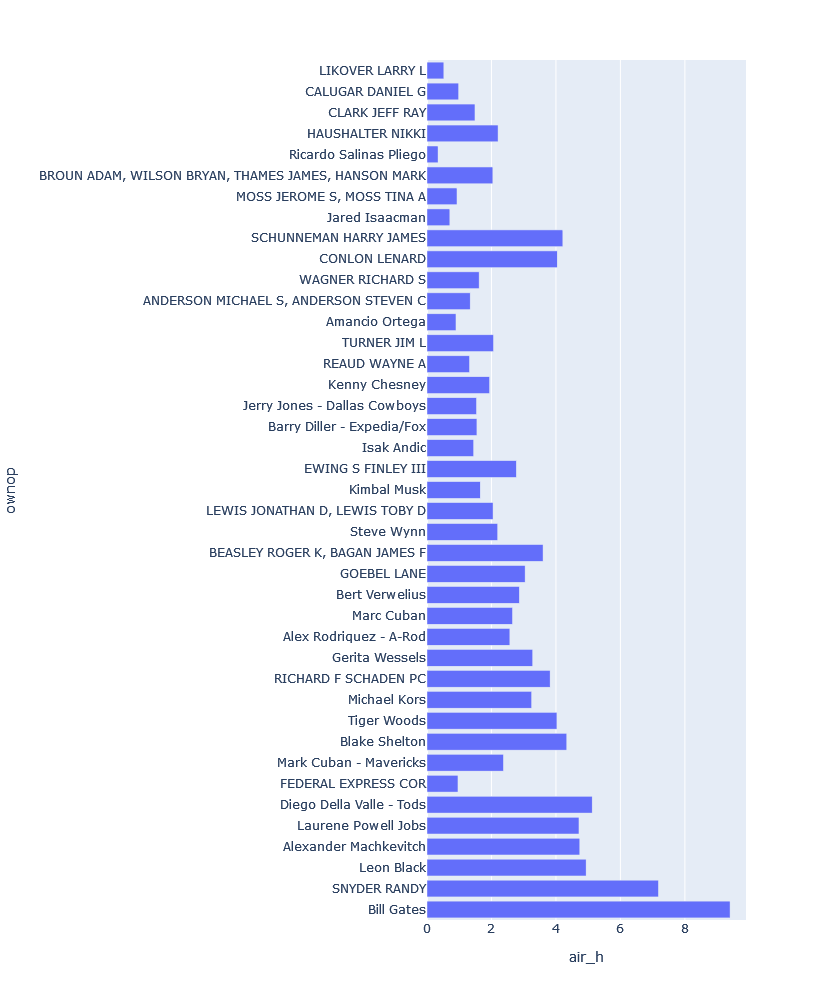

In [197]:
attribution = tick_to_attribution(hist, fuel_consumption, aircrafts)
attribution_compared =  get_per_capita_emissions(attribution, country_co2_emissions)
attribution_compared.cache()


ac = get_individually_owned(attribution_compared, aircrafts)

plot_polluter_rank(ac.toPandas(), x="air_h")

In [165]:
df.to_csv("export/attribution_co2.csv", index=False)

In [43]:
selected_history = ac.select("ownop", "reg").\
  join(hist, on=[ac.reg == hist.r]).\
  select("ownop", "reg", "lat", "lon", "ts").toPandas()
selected_history.to_csv("export/trips_history.csv", index=False)

In [198]:
import plotly.express as px
fig = px.line_geo(selected_history, lat="lat", lon="lon", title="Flight data for trip(s)",  width=1500, height=800)#, color="gs_quartile")
fig.show()

NameError: name 'selected_history' is not defined

In [30]:
import pandas as pd
pd.read_csv("export/attribution_co2.csv", header=0)

Index(['ownop', 'reg', 'air_h', 'co2_tons', 'times_European Union (28)_yr',
       'times_Africa_yr', 'times_Argentina_yr', 'times_United Kingdom_yr',
       'times_United States_yr', 'times_Australia_yr', 'times_China_yr',
       'times_India_yr'],
      dtype='object')

## openSky data

adsbexchange són bastant carbasses. Provem una altra font. 

Tenim dades cada 1 segon, tot i que pel que diuen la xarxa té menor cobertura. https://opensky-network.org/datasets/states/ 

**PROBLEMA** La cobertura es pot veure que falta si mirem vols sobre països de l'est mitjà, 
per exemple plotejant `icao24 like '06a3%'`

```bash
y='2022'
m='06'
days=('06' '13' '20' '27')
hours=('00' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '21' '22' '23')
for d in "${days[@]}"; do 
  dt="$y-$m-$d"
  folder="y=$y/m=$m/d=$d"
  mkdir -p "$folder"
  for h in "${hours[@]}"; do 
    fname=states_$dt-$h.avro.tar
    wget "https://opensky-network.org/datasets/states/$dt/$h/$fname" -P "$folder" && tar -xf "$folder/$fname" -C "$folder" && rm "$folder/$fname"
  done
  rm "$folder/README.txt" "$folder/LICENSE.txt"
done
```

In [8]:
toPd(opensky)

,alert,baroaltitude,callsign,geoaltitude,heading,icao24,lastcontact,lastposupdate,lat,lon,onground,spi,squawk,time,velocity,vertrate,y,m,d
0,False,9144.00,TVF56BF,8976.36,325.792525,39ceab,1.653930e+09,1.653930e+09,54.164337,-2.285784,False,False,0663,1653930000,237.002961,0.00000,2022,5,30
1,False,10447.02,TOM192,10347.96,276.591082,4ac8da,1.653930e+09,1.653930e+09,53.733444,-6.257656,False,False,7627,1653930000,246.504581,3.57632,2022,5,30
2,False,10668.00,EXS71DS,10576.56,122.864061,407267,1.653930e+09,1.653930e+09,52.861862,2.924042,False,False,7507,1653930000,247.434729,0.00000,2022,5,30
3,False,11582.40,BCS995,11551.92,281.867732,440bc6,1.653930e+09,1.653930e+09,51.038198,12.608871,False,False,1000,1653930000,217.631702,0.00000,2022,5,30
4,False,11887.20,KAL288,12336.78,84.382419,71c285,1.653930e+09,1.653930e+09,43.105682,-78.518457,False,False,6277,1653930010,252.260174,0.00000,2022,5,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,10972.80,UAL761,10980.42,282.036343,a2cb32,1.653930e+09,1.653930e+09,54.666619,-11.952709,False,False,6652,1653930010,246.697757,0.00000,2022,5,30
96,False,1363.98,NOZ641,1417.32,178.007906,47a518,1.653930e+09,1.653930e+09,60.421692,11.207854,False,False,3661,1653930010,118.393673,-2.27584,2022,5,30
97,False,12504.42,N711RW,12870.18,140.257809,a98150,1.653930e+09,1.653930e+09,36.155727,-101.637736,False,False,None,1653930010,238.178127,0.65024,2022,5,30
98,False,NaN,None,NaN,127.061735,0d0821,1.653930e+09,NaN,NaN,NaN,False,False,None,1653930010,92.188882,-4.55168,2022,5,30


In [169]:
os_sample = opensky.where("y = 2022 and m = '04'").\
  select( "time", "icao", "callsign", "lat", "lon", "altitude_baro", "onground")
os_sample.show()

+----------+------+--------+-------------------+-------------------+------------------+--------+
|      time|  icao|callsign|                lat|                lon|     altitude_baro|onground|
+----------+------+--------+-------------------+-------------------+------------------+--------+
|1649714400|4bcdea|SXS18V  |  40.00685352390095|  33.02521445534446|           10668.0|   false|
|1649714400|4cafb4|RYR6EQ  |  52.15992736816406|  9.214248657226562|11582.400000000001|   false|
|1649714400|89408c|GFA006  |  50.71033025192002|  5.320892333984375|11269.980000000001|   false|
|1649714400|407cb2|RUK97AN |  52.47601318359375| 6.4980316162109375|11582.400000000001|   false|
|1649714400|4d22af|RYR2PT  |   49.2674560546875|   8.93364539513221|            8420.1|   false|
|1649714410|abe621|N866LF  | 48.035904189287606|-122.89271428034857| 678.1800000000001|   false|
|1649714410|adb723|JBU1374 |  40.89395296775688|-102.95350508256394|          10066.02|   false|
|1649714410|a05b2c|N122AM  |  

In [ ]:
os.

In [172]:
from pyspark.sql.window import Window

def resample(ticks, unix_s_col, plane_identifier="icao", sampling_s=60):
    resampled_col = f"{unix_s_col}_resampled"
    buckets = (col(unix_s_col) / sampling_s).cast("bigint") * sampling_s
    resampled_window = Window.partitionBy(plane_identifier, resampled_col).orderBy(unix_s_col)

    ts_resampled = ticks.withColumn(resampled_col, buckets)
    # Needed to avoid too many files open exceptions
    ts_resampled.cache()

    resampled = ts_resampled.\
      withColumn("_window_rank", row_number().over(resampled_window)).\
      where("_window_rank = 1").drop("_window_rank")
    return resampled

In [173]:
resampled = resample(os_sample, "time")
resampled.cache()

22/09/11 14:04:20 WARN CacheManager: Asked to cache already cached data.


DataFrame[time: int, icao: string, callsign: string, lat: double, lon: double, altitude_baro: double, onground: boolean, time_resampled: bigint]

In [177]:
fig_sample = resampled.where("icao in ('344547', 'e09491', '342294' 'e4835d', 'ac6ffb', '4cc3ef')").\
  orderBy("time_resampled")

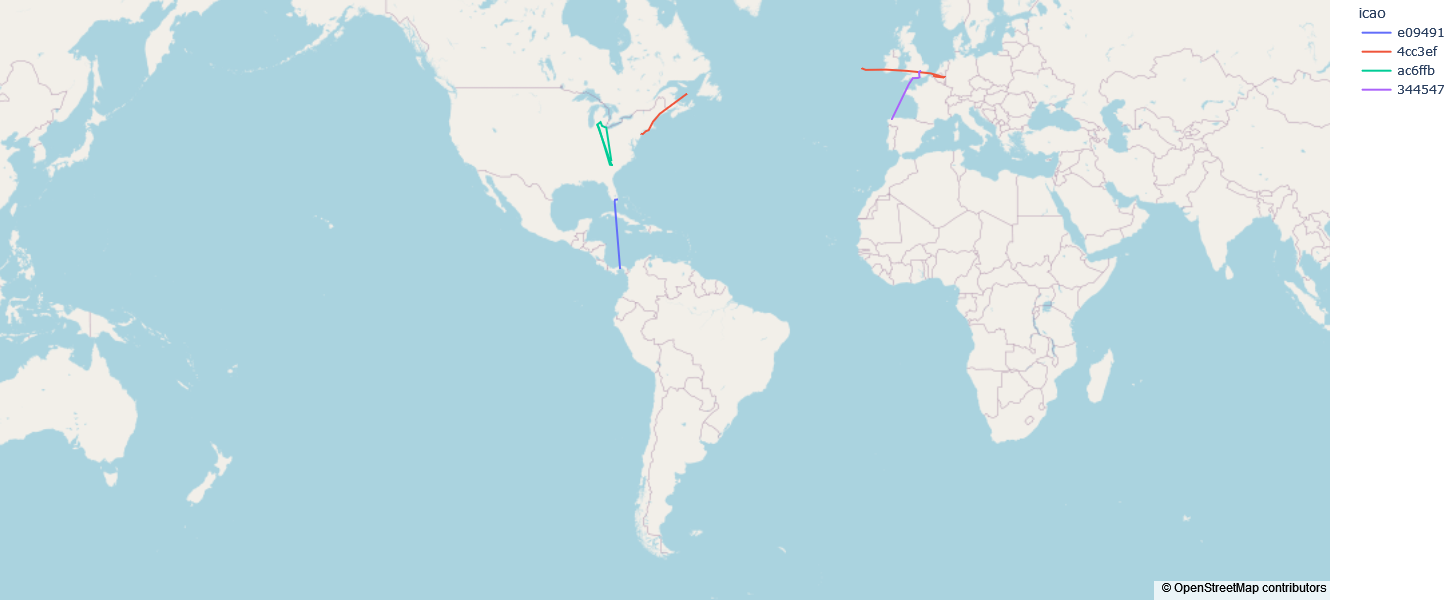

In [184]:
plot_map(fig_sample.toPandas(), color="icao")

In [11]:
os_sample.where("icao24 = '06a30a'").count()

2973

In [58]:
ts_resampled.unpersist()
resampled.unpersist()

DataFrame[time: int, icao24: string, callsign: string, lat: double, lon: double, baroaltitude: double, onground: boolean, lastposupdate: double, time_resampled: bigint]

In [63]:
aircrafts.where("ownop like '%mancio%' or reg in ('LV-IRQ', 'EC-JIL', 'N900JG', 'PR-SMK', 'TF-AAK')").\
  select("icao", "ownop", "reg").show()

+------+--------------------+------+
|  icao|               ownop|   reg|
+------+--------------------+------+
|4cc3ef|                null|TF-AAK|
|e09491|                null|LV-IRQ|
|e4835d|                null|PR-SMK|
|342294|Isak Andic - Mang...|EC-JIL|
|344547|Amancio Ortega - ...|EC-LZU|
|ac6ffb|Jaime Gilinski - ...|N900JG|
+------+--------------------+------+



## Everything together

In [4]:
os_hist = get_individually_owned(opensky, aircrafts)

In [87]:
resampled.groupBy("icao").count().show()

+------+-----+
|  icao|count|
+------+-----+
|7c304a|   45|
|7c62f4|  106|
|a02a3d|  128|
|a02aeb|   86|
|a08247|  280|
|a08a47|  641|
|a0d4b9|   20|
|a0f47b|  919|
|a0ff48|   44|
|a129a5|   88|
|a184be|   25|
|a1a36b|  142|
|a1b272|  141|
|a1bfd1|  454|
|a1c8e6|    9|
|a1e4fa|   76|
|a1f2cc|  243|
|a255c1|   71|
|a30e39|   36|
|a33fa7|   71|
+------+-----+
only showing top 20 rows



In [89]:
ft = compute_flight_time(resampled, 60)

In [95]:
co2 = compute_co2(ft, fuel_consumption, aircrafts)
with_type = ft.join(aircrafts.select("icao", "icaotype"), on="icao", how="left")
with_type\
      .join(fuel_consumption.select(["icaotype", "galph"]) , on="icaotype", how="left")\
      .withColumn("fuel_used_kg", col("air_s")/3600 * col("galph") * 3.04)\
      .withColumn("co2_tons", col("fuel_used_kg") * 3.15 / 907.185)\
      .show()

+--------+------+-----+------------------+-----+------------+--------+
|icaotype|  icao|air_s|             air_h|galph|fuel_used_kg|co2_tons|
+--------+------+-----+------------------+-----+------------+--------+
|    RV14|7c304a| 5100|1.4166666666666667| null|        null|    null|
|    C310|7c62f4| 7200|               2.0| null|        null|    null|
|    null|a02a3d|10080|               2.8| null|        null|    null|
|    null|a02aeb| 7560|               2.1| null|        null|    null|
|    null|a08247|19200| 5.333333333333333| null|        null|    null|
|    null|a08a47|40860|             11.35| null|        null|    null|
|    null|a0d4b9| 3600|               1.0| null|        null|    null|
|    null|a0f47b|57540|15.983333333333333| null|        null|    null|
|    null|a0ff48| 5040|               1.4| null|        null|    null|
|    null|a129a5| 7680|2.1333333333333333| null|        null|    null|
|    null|a184be| 3900|1.0833333333333333| null|        null|    null|
|    n

In [91]:
co2.count()

23

In [47]:
resampled = resample(os_hist, "time", sampling_s=60)
resampled.cache()

attribution = tick_to_attribution(resampled, fuel_consumption, aircrafts, s_between_ticks = 60)
attribution_compared =  get_per_capita_emissions(attribution, country_co2_emissions)
attribution_compared.cache()
#ac = get_individually_owned(attribution_compared, aircrafts)
countries_info = aircrafts.select("icao", "model", "icaotype", "country", "wiki_page", "alpha-2", 
                              "region", "sub-region", "intermediate-region")
ac_with_countries = attribution_compared.join(countries_info, on="icao").dropDuplicates()

22/09/16 20:11:55 WARN CacheManager: Asked to cache already cached data.
22/09/16 20:11:55 WARN CacheManager: Asked to cache already cached data.


In [6]:
os_hist.count()

18289922

In [81]:
attribution.count()

27

In [76]:
countries_info.dropDuplicates().count()

134765

In [10]:
ac_with_countries.count()

1220

In [9]:
ac_with_countries.show()

+------+--------------------+------------------+------------------+----------------------------+------------------+------------------+-----------------------+----------------------+------------------+-----------------+------------------+--------------------+--------+---------+--------------------+-------+--------+--------------------+-------------------+
|  icao|               ownop|             air_h|          co2_tons|times_European Union (28)_yr|   times_Africa_yr|times_Argentina_yr|times_United Kingdom_yr|times_United States_yr|times_Australia_yr|   times_China_yr|    times_India_yr|               model|icaotype|  country|           wiki_page|alpha-2|  region|          sub-region|intermediate-region|
+------+--------------------+------------------+------------------+----------------------------+------------------+------------------+-----------------------+----------------------+------------------+-----------------+------------------+--------------------+--------+---------+---------

In [11]:
df = ac_with_countries.toPandas()
df.to_csv("export/attribution_co2.csv", index=False)

In [12]:
ac_with_countries.count()

1220

In [26]:
followed_planes = [r.asDict()["icao"] for r in ac.select("icao").collect()]
for icao in followed_planes:
    df = resampled.where(f"icao = '{icao}'").toPandas()
    df.to_csv(f"export/trips_history/{icao}.csv", index=False)

In [15]:
aircrafts.where("ownop like 'Elo%'").show()

+---+--------+-------+----+--------+------------+---+-----+----------+----+-------------+---------+----------+-------+---------+-----+--------+-------+-------+------+----------+-------------------+
|reg|faa_ladd|faa_pia|icao|icaotype|manufacturer|mil|model|short_type|year|ownop_country|known_for|ownop_type|sources|wiki_page|ownop|reg_code|country|alpha-2|region|sub-region|intermediate-region|
+---+--------+-------+----+--------+------------+---+-----+----------+----+-------------+---------+----------+-------+---------+-----+--------+-------+-------+------+----------+-------------------+
+---+--------+-------+----+--------+------------+---+-----+----------+----+-------------+---------+----------+-------+---------+-----+--------+-------+-------+------+----------+-------------------+



In [57]:
df.country.unique()

array(['Guam', 'Mexico', 'Spain', 'Canada', 'United Arab Emirates',
       'Liechtenstein', 'Switzerland', 'Italy', 'Argentina',
       'Equatorial Guinea', 'Netherlands', 'Isle of Man'], dtype=object)

In [58]:
len(df.index)

190

In [21]:
spark.stop()

22/09/24 19:04:24 WARN BasicWriteTaskStatsTracker: Expected 1 files, but only saw 0. This could be due to the output format not writing empty files, or files being not immediately visible in the filesystem.
22/09/24 19:04:24 ERROR Utils: Uncaught exception in thread Executor task launch worker for task 25.0 in stage 8.0 (TID 1959)
java.lang.NullPointerException
	at org.apache.spark.scheduler.Task.$anonfun$run$3(Task.scala:157)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1484)
	at org.apache.spark.scheduler.Task.run(Task.scala:155)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.T

In [48]:
aircrafts

DataFrame[reg: string, faa_ladd: boolean, faa_pia: boolean, icao: string, icaotype: string, manufacturer: string, mil: boolean, model: string, short_type: string, year: string, country: string, known_for: array<string>, ownop_type: string, sources: array<string>, wiki_page: string, ownop: string, reg_code: string, country: string, alpha-2: string, region: string, sub-region: string, intermediate-region: string]